
# Sounding as Dataset Example

Use MetPy to make a Skew-T LogP plot from an xarray Dataset after computing LCL parcel profile.


## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

## Obtain Data and Format

Upper air data can be obtained using the siphon package, but for this example we will use some of MetPy's sample data.
`as_file_obj=False), skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)` is necessary due to the formatting of the MetPy sample data. This formatting is not needed when using upper air data obtained via Siphon. Obtaining data with Siphon will be covered in a later notebook. 

In [2]:
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

sounding_data = pd.read_fwf(get_test_data('20110522_OUN_12Z.txt', as_file_obj=False),
                 skiprows=7, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all not a number (NaN) values for temperature, dewpoint, and winds
sounding_data = sounding_data.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'),
               how='all').reset_index(drop=True)

## Assign Units

We will pull the data out of the example dataset into individual variables and assign units. This is explained in further detain in the Simple Sounding notebook and in the [Metpy documentation](https://unidata.github.io/MetPy/latest/tutorials/unit_tutorial.html).


In [3]:
pres = sounding_data['pressure'].values * units.hPa
temp = sounding_data['temperature'].values * units.degC
dewpoint = sounding_data['dewpoint'].values * units.degC
wind_speed = sounding_data['speed'].values * units.knots
wind_dir = sounding_data['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

lcl_ds = mpcalc.parcel_profile_with_lcl_as_dataset(pres, temp, dewpoint)

In [4]:
lcl_ds

Magnitude,[22.2 21.4 21.254116023095705 20.8 20.4 19.3 18.8 20.0 22.2 23.2 23.2 22.0 21.8 19.2 18.2 16.5 13.7 10.9 7.6 2.3 0.6 -2.9 -2.9 -4.5 -4.4 -4.3 -3.7 -3.3 -3.9 -3.9 -6.3 -6.3 -11.1 -13.7 -17.1 -18.3 -23.9 -24.9 -26.6 -37.9 -40.7 -43.5 -46.3 -52.1 -52.3 -54.1 -55.9 -56.5 -56.5 -56.5 -56.5 -57.9 -56.9 -59.3 -58.9 -59.0 -59.5 -59.9 -59.2 -58.7 -57.9 -56.7 -56.5 -57.7 -59.8 -60.1 -61.0 -62.9 -64.3 -63.3 -64.3]
Units,degree_Celsius
Magnitude,[21.0 20.7 20.65137200769857 20.5 20.4 19.3 18.8 20.0 19.0 13.3 13.2 6.0 3.8 -1.7 -3.8 -4.7 -6.2 -7.7 -9.4 -10.9 -11.4 -12.9 -12.9 -14.5 -14.4 -14.3 -24.7 -36.3 -31.9 -31.8 -27.4 -27.3 -29.1 -31.3 -34.1 -32.3 -37.0 -37.9 -39.3 -48.1 -50.3 -52.5 -55.3 -62.1 -62.3 -64.1 -65.9 -66.5 -66.5 -66.5 -66.5 -67.9 -66.9 -69.3 -68.9 -69.0 -69.5 -69.9 -69.2 -68.7 -67.9 -66.7 -66.5 -67.7 -69.8 -70.1 -71.0 -72.9 -73.3 -73.3 -74.3]
Units,degree_Celsius
Magnitude,[295.34999999999997 294.20887396170207 293.86308176800566 293.40999598297236 292.9605366516025 292.1693871501292 291.83484364691674 291.5963220045112 291.4361963323114 290.92178176440206 290.9095176897098 289.95324507449203 289.78361661237284 288.3800144790221 287.84779705003416 287.0630619897046 285.72612496874217 284.3692057775776 282.77536756242387 280.10893536751206 279.23922058870653 277.1232960053971 277.09664797744415 275.61892684782913 275.5274725480196 275.47810502547424 275.1229494554376 274.69078901458516 273.9555257073228 273.9331702389749 272.29917542768135 272.26757383165204 269.0055991481036 267.0737915535153 264.5137445137853 263.4630088557104 259.2614990911962 258.4793263502483 257.10515037181517 247.80090458906085 245.34140461782874 242.81799102546762 240.01050451730532 231.91012214705813 231.6657585024839 224.08711786721128 221.24235897557074 218.27111704455257 217.35421917769239 217.2002322728787 215.16743230137462 212.25494058759193 209.5659695215338 204.6164100334584 203.1411807522514 202.84269696570666 201.25632033826017 200.48922395508256 200.0640310151734 199.71438559354843 198.14083284802103 197.341775309911 196.1273252033388 194.6024080711456 191.9334291191558 191.50099464989884 189.25609420942234 184.69553916489568 183.73898623782966 181.291232491021 179.27154995827192]
Units,kelvin


## Create Sounding Plot

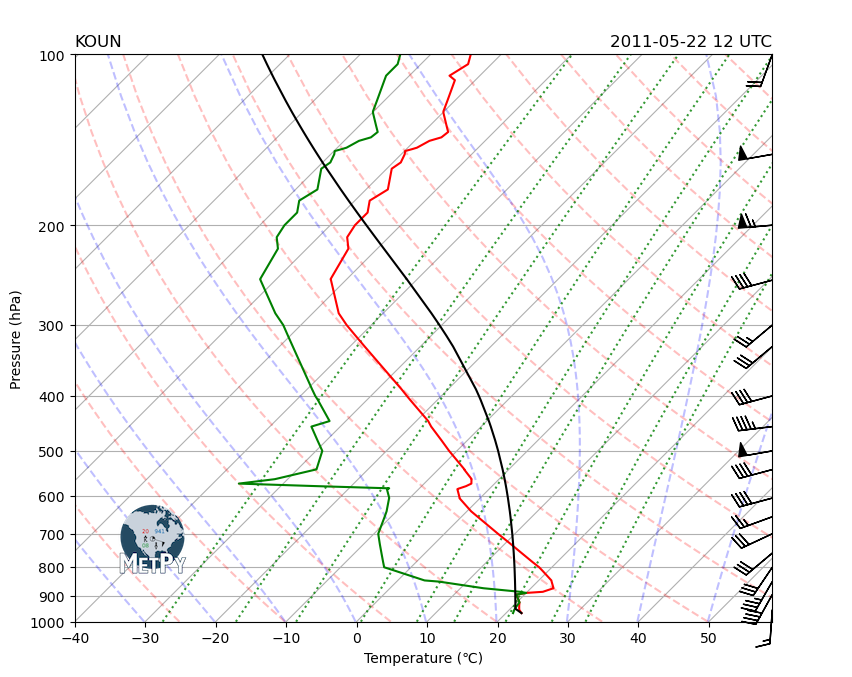

In [5]:
# Create figure and set size
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45)

# Plot the data using the data from the xarray Dataset including the parcel temperature with
# the LCL level included
skew.plot(lcl_ds.isobaric, lcl_ds.ambient_temperature, 'red')
skew.plot(lcl_ds.isobaric, lcl_ds.ambient_dew_point, 'green')
skew.plot(lcl_ds.isobaric, lcl_ds.parcel_temperature.metpy.convert_units('degC'), 'black')

# Plot wind barbs
my_interval = np.arange(100, 1000, 50) * units('hPa') #set spacing interval
ix = mpcalc.resample_nn_1d(pres, my_interval) #find nearest indices for chosen interval
skew.plot_barbs(pres[ix], u[ix], v[ix], xloc=1) #plot values closest to chosen interval

# Improve labels and set axis limits
skew.ax.set_xlabel('Temperature (\N{DEGREE CELSIUS})')
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 59)

# Add the relevant special lines throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 15) * units.K, alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 10) * units.K, alpha=0.25, color='tab:green')
skew.plot_mixing_lines(pressure=np.arange(1000, 99, -25) * units.hPa, linestyle='dotted', color='tab:blue')

# Add the MetPy logo!
fig = plt.gcf()
add_metpy_logo(fig, 115, 100, size='small');

# Add titles
plt.title('KOUN', loc='left')
plt.title('2011-05-22 12 UTC', loc='right');